# Proxy Target Metrics for Continuous Treatment


## Summary 


This notebooks explores the use of proxy targets for the treatment effect when doing model selection. The issue in causal inference is that we can never observe the true treatment effect for any individual unit, $\tau_i=Y_0-Y_1$. This makes it so that we can't compute MSE, or R2 or correlation between our model's estimate for $\tau$ and the true $\tau$. 


One way around this is to create target variables that approximate $\tau_i$, let's call them $\hat{\tau}_i$, and use that as if it was the true treatment effect. That is, we can calculate predictive metrics between our model's estimate and $\hat{\tau}_i$. To see the effectiveness of these techniques, we'll use simulated data where we know the true $\tau_i$. Then, we'll check if the MSE between the model's estimate for the treatment effect and the true $\tau_i$ agrees with the MSE between the model's estimate and the proxy target.


We do this by computing a learning curve, that is, fitting the model multiple times, each time with more training samples. Then, check the model performance on the holdout both in terms of the oracle (known) causal MSE and the feasible (proxy target) MSE. Ideally, both should decrease as the training sample increases and in line with each other.


## Proxy Targets


For all targets, we have to estimate models on the holdout set. To avoid overfitting, we always get out-of-fold predictions from these models.


* $\hat{y}_0$ is a model that estimates $E[y|X, T=0]$
* $\hat{y}_1$ is a model that estimates $E[y|X, T=1]$
* $\hat{y}$ is a model that estimates $E[y|X, T]$
* $\hat{p}$ is a model that estimates $P(T|X)$


Notice that the treatment intensity is part of $X$.


$$
\tau = cov(y, t)/var(t)
$$


### IPW Target


$$
\hat{\tau} = \dfrac{y(T-\hat{p})}{\hat{p} (1-\hat{p})}
$$


### Doubly Robust Target


$$
\hat{y} =  \hat{y}_0 (1-T) + \hat{y}_1 T
$$


$$
\hat{\tau} = \hat{y}_0 - \hat{y}_1 + \dfrac{(y-\hat{y})(T-\hat{p})}{\hat{p} (1-\hat{p})}
$$


### Double-ML Target


$$
\tilde{y} = y - \hat{y}
$$


$$
\tilde{t} = t - \hat{p}
$$


$$
\hat{\tau} = \tilde{y}/\tilde{t}
$$


$$
\hat{w} = \tilde{t}^2
$$


## Conclusion


All proxy targets seem to have a learning curve similar to the one that uses the true $\tau$ target. However, the proxy target learning curve has higher variance than the oracle one. On that criteria, the IPW proxy target seems to be the one with higher variance, while the double-ml and doubly-robust target seems to perform quite similarly.


In [1]:
import pandas as pd
import numpy as np
from toolz import curry
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.special import expit

from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.model_selection import cross_val_predict, train_test_split, cross_val_score
from sklearn.metrics import r2_score, roc_auc_score

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, QuantileTransformer


# DGP: Continuous Treatment and Biased Assignment


The data generating process has a continuous treatment that can take 4 values. Hence, the treatment effect is the derivative $\partial Y(t)/\partial t$. However, since most proxy targets can only be created with a binary treatment, we recast the problem as follows:


1. We assign the lowest (baseline) treatment to be the control group and all other groups to be the treated group
2. We create a variable treatment-baseline to represent the treatment intensity or dosage
3. We treat the treatment dosage as if it was a feature that modifies the binary effect. Ideally, the model we build should pick up that the higher the treatment intensity, the higher the treatment effect.


In this DGP, both the treatment assignment (test vs control) and the treatment dosage are biased. However, we observe all the confounders, meaning that it satisfies the CIA.


In [2]:

def neg_exponential(treatment, convergence, asymptote):
    return asymptote * (1 - np.exp(-convergence * treatment))


def gen_biased_dataset(n,
                n_x=20,
                delta_range = (10, 30),
                non_causal_range = (10, 200),
                asymptote_range = (1, 200),
                conv_range = (0.0005, 0.1),
                seed=1
               ):
    
    
    np.random.seed(seed)
    poly_maker = PolynomialFeatures(degree=2)

    X_raw = np.random.normal(0, 1, (n, n_x))
    X = poly_maker.fit_transform(X_raw)

    np.random.seed(seed+1)
    asymptote_param = np.random.uniform(-1, 1, size=X.shape[1])*np.random.binomial(1, 0.3, X.shape[1])

    np.random.seed(seed+2)
    convergence_param = np.random.uniform(-1, 1, size=X.shape[1])*np.random.binomial(1, 0.3, X.shape[1])

    np.random.seed(seed+3)
    confounder_param = np.random.uniform(-1, 1, size=X.shape[1])*np.random.binomial(1, 0.3, X.shape[1])
    
    np.random.seed(seed+4)
    predictive_param = np.random.uniform(0, 1, size=X.shape[1])*np.random.binomial(1, 0.3, X.shape[1])

    asymptote = MinMaxScaler(asymptote_range).fit_transform(X.dot(asymptote_param).reshape(-1,1)).flatten()
    convergence = MinMaxScaler(conv_range).fit_transform(X.dot(convergence_param).reshape(-1,1)).flatten()
    
    non_causal_y = MinMaxScaler(non_causal_range).fit_transform(X.dot(predictive_param).reshape(-1,1)).flatten()
    
    confounder = X.dot(asymptote_param).reshape(-1,1)
   
    treatment_baseline = 10
    assigned_delta_unif = QuantileTransformer().fit_transform(np.random.normal(confounder, 5))
    assigned_delta = MinMaxScaler(delta_range).fit_transform(assigned_delta_unif).round(-1).flatten()
    
    ps = expit((confounder-confounder.mean()) / confounder.std()).flatten()
    is_test = np.random.binomial(1, ps, n)
    
    treatment = treatment_baseline+assigned_delta*is_test
    
    causal_y = neg_exponential(treatment, convergence, asymptote)
    
    y = np.random.normal(non_causal_y+causal_y, scale=50)
    
    return pd.DataFrame({
        "y": y,
        "non_causal_y":non_causal_y,
        "causal_y": causal_y,
        "t": treatment, 
        "test": is_test==1,
        "assigned_delta": assigned_delta, 
        "asymptote": asymptote,
        "convergence": convergence,
        "confounder": confounder.flatten(),
        "ps": ps,
    }).assign(**{f"f_{i}": X_raw[:, i] for i in range(n_x)})
    


In [3]:
n = 60000

df_bias = gen_biased_dataset(n, seed=10)
df_bias.head()

,y,non_causal_y,causal_y,t,test,assigned_delta,asymptote,convergence,confounder,ps,...,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19
0,174.127864,107.833972,106.541844,30.0,True,20.0,130.412325,0.056602,3.334668,0.726781,...,0.433026,1.203037,-0.965066,1.028274,0.228630,0.445138,-1.136602,0.135137,1.484537,-1.079805
1,165.596249,103.765007,62.718613,10.0,False,20.0,141.731061,0.058433,6.361407,0.831738,...,-0.267317,-0.549309,0.132708,-0.476142,1.308473,0.195013,0.400210,-0.337632,1.256472,-0.731970
2,278.647093,78.110452,110.670029,30.0,True,20.0,140.510742,0.051647,6.035082,0.822180,...,-0.025905,0.289094,-0.539879,0.708160,0.842225,0.203581,2.394704,0.917459,-0.112272,-0.362180
3,225.471281,95.699713,111.173666,30.0,True,20.0,126.221546,0.070893,2.214014,0.678944,...,0.319356,0.460903,-0.215790,0.989072,0.314754,2.467651,-1.508321,0.620601,-1.045133,-0.798009
4,257.610075,97.045328,132.757337,40.0,True,30.0,147.743807,0.057208,7.969274,0.872936,...,1.107708,0.244544,-0.061912,-0.753893,0.711959,0.918269,-0.482093,0.089588,0.826999,-1.954512


## Visualize Counterfactuals

<AxesSubplot:>

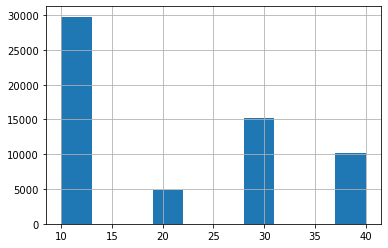

In [4]:
df_bias["t"].hist()

<AxesSubplot:xlabel='t', ylabel='cf_y'>

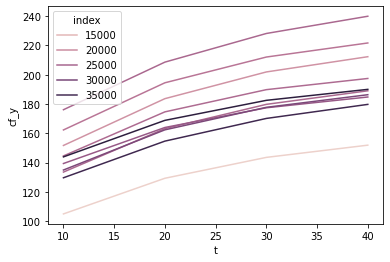

In [5]:
treatment_array = pd.DataFrame(dict(t=[10, 20, 30, 40], key=1))

plt_df = (df_bias
 .sample(10, random_state=123)
 .reset_index()
 .assign(key=1)
 .drop(columns=["t"])
 .merge(treatment_array)
 .assign(cf_y = lambda d: d["non_causal_y"] + neg_exponential(d["t"], d["convergence"], d["asymptote"]))
)

sns.lineplot(data=plt_df, x="t", y="cf_y", hue="index")

## Visualize Bias 

<AxesSubplot:xlabel='ps', ylabel='Count'>

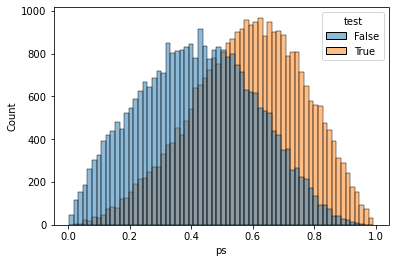

In [6]:
sns.histplot(
    data=df_bias,
    x="ps",
    hue="test"
)

In [7]:
df_bias[["ps", "confounder", "test"]].corr()

,ps,confounder,test
ps,1.000000,0.985942,0.405237
confounder,0.985942,1.000000,0.399335
test,0.405237,0.399335,1.000000


In [8]:
features = [f"f_{i}" for i in range(20)]
cross_val_score(LGBMClassifier(), df_bias[features+["assigned_delta"]], df_bias["test"]*1, scoring="roc_auc")

array([0.68494733, 0.67762008, 0.67392235, 0.68193011, 0.68316415])

# Fit a Very Simple S-Learner

In [9]:
train_df, holdout_df = train_test_split(df_bias)
train_df.shape, holdout_df.shape

((45000, 30), (15000, 30))

In [10]:
model = LGBMRegressor()
model.fit(train_df[features+["t"]], train_df["y"])

LGBMRegressor()

In [11]:
def predict_from_model(df, model):
    baseline=df[~df["test"]]["t"].mean()
    return  df.assign(
        estimated_y = lambda d: model.predict(df[features+["t"]]),
        estimated_delta_y = lambda d: model.predict(d[features].assign(t=baseline+d["assigned_delta"])) - model.predict(d[features].assign(t=baseline)),
        estimated_delta_y_delta_t = lambda d: d["estimated_delta_y"]/d["assigned_delta"],
        true_delta_y = lambda d: neg_exponential(baseline+d["assigned_delta"], d["convergence"], d["asymptote"]) - neg_exponential(baseline, d["convergence"], d["asymptote"]),
        true_delta_y_delta_t = lambda d: d["true_delta_y"]/d["assigned_delta"]
).drop(columns=features)
    

In [12]:
holdout_pred = predict_from_model(holdout_df, model)

holdout_pred.head()

,y,non_causal_y,causal_y,t,test,assigned_delta,asymptote,convergence,confounder,ps,estimated_y,estimated_delta_y,estimated_delta_y_delta_t,true_delta_y,true_delta_y_delta_t
33537,140.642332,80.368493,80.789669,30.0,True,20.0,103.000743,0.051138,-3.995453,0.372313,168.801000,52.075820,2.603791,39.555013,1.977751
56188,38.992464,73.940265,39.996369,10.0,False,10.0,111.120296,0.044619,-1.824206,0.480560,120.403829,24.848342,2.484834,25.600173,2.560017
32776,159.774608,114.226035,46.789327,10.0,False,20.0,108.931665,0.056129,-2.409467,0.450756,143.211253,44.566664,2.228333,41.918923,2.095946
250,149.037435,88.520643,105.769030,40.0,True,30.0,123.343797,0.048713,1.444476,0.643682,205.734339,66.830571,2.227686,58.206241,1.940208
42840,191.116356,83.516222,35.832857,10.0,False,20.0,95.926473,0.046768,-5.887181,0.287084,142.116621,33.922879,1.696144,36.510127,1.825506


# Propensity Score Pseudo Target

In [13]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10)

prob = np.zeros(len(holdout_df))

for train_index, test_index in kf.split(holdout_df):
    
    modelt = LGBMClassifier()
    
    modelt.fit(holdout_df.iloc[train_index][features+["assigned_delta"]], holdout_df.iloc[train_index]["test"]*1)
    
    prob[test_index] += modelt.predict_proba(holdout_df.iloc[test_index][features+["assigned_delta"]])[:, 1]
    


## Check Calibration

In [14]:
prob.mean(), holdout_pred["test"].mean()

(0.5009563722490668, 0.5009333333333333)

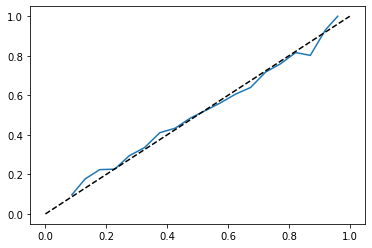

In [15]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(holdout_pred["test"], prob,  n_bins=20, )

plt.plot(prob_pred, prob_true)
plt.plot([0, 1], [0, 1], color="black", ls="dashed") 

In [16]:
reisz = (holdout_pred["test"]-prob)/np.clip(prob * (1 - prob), .01, np.inf)
ips_tau_hat = holdout_pred["y"]*reisz

## Learning Curve

In [17]:
np.random.seed(321)

def fit_model(df):
    return LGBMRegressor().fit(df[features+["t"]], df["y"])

sample_sizes = np.linspace(1000, train_df.shape[0], 15).astype(int)

models = [fit_model(train_df.iloc[0:train_size])
          for train_size in sample_sizes]


### Predictive Metric

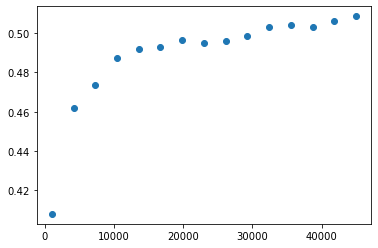

In [18]:
corr_coef=[]
for model, size in zip(models, sample_sizes):
    pred_df = predict_from_model(holdout_df, model)
    corr_coef.append(pred_df[["y", "estimated_y"]].corr(method="spearman")["y"]["estimated_y"])
    
plt.scatter(sample_sizes, corr_coef)

### Oracle Causal MSE

In [19]:
from sklearn.metrics import mean_squared_error

mse = []
for model, size in zip(models, sample_sizes):
    pred_df = predict_from_model(holdout_df, model)
    mse.append(mean_squared_error(pred_df["true_delta_y"], pred_df["estimated_delta_y"]))

Text(0, 0.5, 'oracle causal mse')

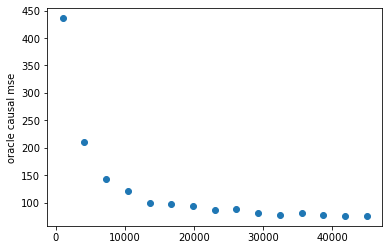

In [20]:
plt.scatter(sample_sizes, mse)
plt.ylabel("oracle causal mse")

### Feasible Causal MSE

In [21]:
mse = []
for model, size in zip(models, sample_sizes):
    pred_df = predict_from_model(holdout_df, model)
    mse.append(mean_squared_error(ips_tau_hat, pred_df["estimated_delta_y"]))

Text(0, 0.5, 'feasible causal mse')

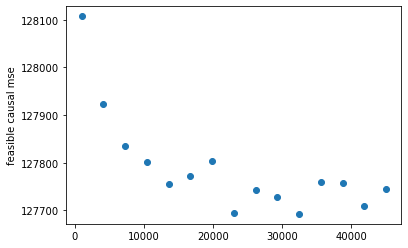

In [22]:
plt.scatter(sample_sizes, mse)
plt.ylabel("feasible causal mse")

# Doubly Robust Pseudo Target

In [23]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10)


y_given_t0 = np.zeros(len(holdout_df))
y_given_t1 = np.zeros(len(holdout_df))
prob = np.zeros(len(holdout_df))

for train_index, test_index in kf.split(holdout_df):
    
    modely_t0 = LGBMRegressor()
    modely_t1 = LGBMRegressor()
    modelt = LGBMClassifier()
    
    modely_t0.fit(holdout_df.iloc[train_index].query("~test")[features+["t"]], holdout_df.iloc[train_index].query("~test")["y"])
    modely_t1.fit(holdout_df.iloc[train_index].query("test")[features+["t"]], holdout_df.iloc[train_index].query("test")["y"])
    modelt.fit(holdout_df.iloc[train_index][features+["assigned_delta"]], holdout_df.iloc[train_index]["test"]*1)
    
    y_given_t0[test_index] += modely_t0.predict(holdout_df.iloc[test_index][features+["t"]])
    y_given_t1[test_index] += modely_t1.predict(holdout_df.iloc[test_index][features+["t"]])
    prob[test_index] += modelt.predict_proba(holdout_df.iloc[test_index][features+["assigned_delta"]])[:, 1]
    


In [24]:
y_given_t1.mean(), holdout_df.query("test")["y"].mean()

(170.19183508877603, 184.00909932654253)

In [25]:
y_given_t0.mean(), holdout_df.query("~test")["y"].mean()

(132.9832661242331, 131.68847625031802)

In [26]:
prob.mean(), holdout_df["test"].mean()

(0.5009563722490668, 0.5009333333333333)

In [27]:
reg_preds_t = y_given_t0 * (1 - holdout_df["test"]) + y_given_t1 * holdout_df["test"]

dr_tau = y_given_t1 - y_given_t0
reisz = (holdout_df["test"]-prob)/np.clip(prob * (1 - prob), .01, np.inf)
dr_tau += (holdout_df["y"] - reg_preds_t)*reisz

### Feasible Causal MSE

In [28]:
mse = []
for model, size in zip(models, sample_sizes):
    pred_df = predict_from_model(holdout_df, model)
    mse.append(mean_squared_error(dr_tau, pred_df["estimated_delta_y"]))

Text(0, 0.5, 'feasible causal mse')

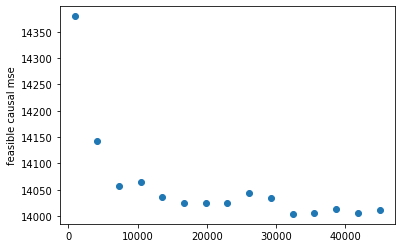

In [29]:
plt.scatter(sample_sizes, mse)
plt.ylabel("feasible causal mse")

# Double-ML Pseudo Target

In [30]:
from sklearn.model_selection import cross_val_predict


model_t = LGBMClassifier()
model_y = LGBMRegressor()

t_res = holdout_df["test"] - cross_val_predict(model_t, holdout_df[features+["assigned_delta"]], holdout_df["test"]*1, cv=10, method="predict_proba")[:, 1]
y_res = holdout_df["y"] - cross_val_predict(model_y, holdout_df[features+["assigned_delta"]], holdout_df["y"], cv=10)

w = t_res ** 2 
tau_hat_dml = y_res / t_res

### Feasible Causal MSE

In [31]:
mse = []
for model, size in zip(models, sample_sizes):
    pred_df = predict_from_model(holdout_df, model)
    mse.append(mean_squared_error(tau_hat_dml, pred_df["estimated_delta_y"], sample_weight=w))

Text(0, 0.5, 'causal mse')

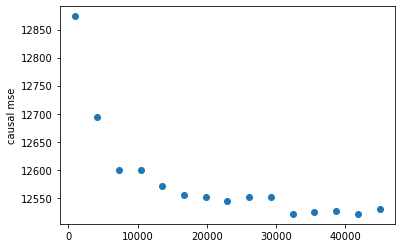

In [32]:
plt.scatter(sample_sizes, mse)
plt.ylabel("causal mse")